# Plot how distance between song-driven MA trajectories changes over time

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
NTR = 30
T_SNPS = range(1, 320, 8)  # snippet lengths to fetch

ds = np.nan*np.zeros((len(T_SNPS), NTR))  # pairwise distances between neural song snippet representations

durs = []
masses = []

rs_final = []
rs_final_scrambled = []

# save some example snippets and responses
snp_xpls = []
snp_xpl_scrambleds = []

rs_full_xpl = []
rs_full_xpl_scrambled = []


for cT_SNP, T_SNP in enumerate(T_SNPS):
    sys.stdout.write(f'T_SNP {T_SNP}: ')
    
    NT_SNP = int(round(T_SNP*FPS))
    t_snp = np.arange(NT_SNP)*DT

    snps = []

    for csng, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP)]
        
        snps.extend(segs)

    snps_scrambled = [snp[np.random.permutation(len(snp))] for snp in snps]
    
    snps = np.array(snps)
    nsnp = len(snps)
    
    snps_scrambled = np.array(snps_scrambled)

    sys.stdout.write(f'{nsnp} snippets')

    for ctr in range(NTR):
        sys.stdout.write('.')
        isnps = np.random.choice(range(len(snps)), 2, replace=False)
        r_pair = []

        for isnp in isnps:
            # get neural response
            snp = snps[isnp]
            i_s = (snp == 1).astype(float)
            i_p = (snp == 2).astype(float)

            t_snp = np.arange(len(snp))*DT

            rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]

            r_pair.append(rs[-1, :])
            
            rs_final.append(rs[-1, :])
            
            durs.append(T_SNP)
            masses.append(np.sum(snp > 0)*DT)
            
            # get neural response to scrambled snippet
            snp_scrambled = snps_scrambled[isnp]
            
            i_s_scrambled = (snp_scrambled == 1).astype(float)
            i_p_scrambled = (snp_scrambled == 2).astype(float)
            
            rs_scrambled = smlt(i_s_scrambled, i_p_scrambled, tau_r, tau_a, x_s, x_p)[0]
            
            rs_final_scrambled.append(rs_scrambled[-1, :])
            
            if np.random.rand() < .1:  # randomly save some examples
                snp_xpls.append(snp.copy())
                rs_full_xpl.append(rs.copy())
                
                snp_xpl_scrambleds.append(snp_scrambled.copy())
                rs_full_xpl_scrambled.append(rs_scrambled.copy())
                

        d = np.linalg.norm(r_pair[0] - r_pair[1])
        
        ds[cT_SNP, ctr] = d
    print('')
    
durs = np.array(durs)
masses = np.array(masses)

T_SNP 1: 4272 snippets..............................
T_SNP 9: 436 snippets..............................
T_SNP 17: 177 snippets..............................
T_SNP 25: 125 snippets..............................
T_SNP 33: 104 snippets..............................
T_SNP 41: 95 snippets..............................
T_SNP 49: 93 snippets..............................
T_SNP 57: 92 snippets..............................
T_SNP 65: 90 snippets..............................
T_SNP 73: 88 snippets..............................
T_SNP 81: 86 snippets..............................
T_SNP 89: 83 snippets..............................
T_SNP 97: 81 snippets..............................
T_SNP 105: 81 snippets..............................
T_SNP 113: 79 snippets..............................
T_SNP 121: 77 snippets..............................
T_SNP 129: 76 snippets..............................
T_SNP 137: 75 snippets..............................
T_SNP 145: 75 snippets..............................
T_

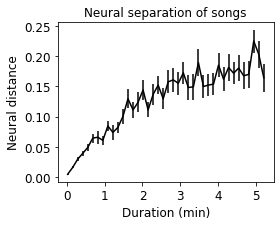

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.25), tight_layout=True)
ax.errorbar(np.array(T_SNPS)/60, ds.mean(1), yerr=ds.std(1)/np.sqrt(NTR), c='k')

set_plot(ax, x_label='Duration (min)', y_label='Neural distance', title='Neural separation of songs')
fig.savefig('ms/fig_4_song_separation.svg')

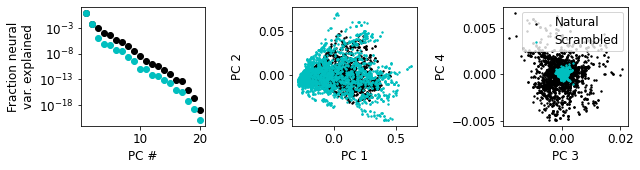

In [12]:
rs_final = np.array(rs_final)
pca = decomposition.PCA().fit(rs_final)
rs_final_pca = pca.transform(rs_final)

rs_final_scrambled = np.array(rs_final_scrambled)
pca_scrambled = decomposition.PCA().fit(rs_final_scrambled)
rs_final_scrambled_pca = pca_scrambled.transform(rs_final_scrambled)

fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), tight_layout=True)
axs[0].scatter(1+np.arange(N), pca.explained_variance_ratio_, c='k')
axs[0].scatter(1+np.arange(N), pca_scrambled.explained_variance_ratio_, c='c')
axs[0].set_yscale('log')

set_plot(axs[0], x_label='PC #', y_label='Fraction neural\nvar. explained')

axs[1].scatter(rs_final_pca[:, 0], rs_final_pca[:, 1], c='k', s=2)
axs[1].scatter(rs_final_scrambled_pca[:, 0], rs_final_scrambled_pca[:, 1], c='c', s=2)

set_plot(axs[1], x_label='PC 1', y_label='PC 2')

axs[2].scatter(rs_final_pca[:, 2], rs_final_pca[:, 3], c='k', s=2)
axs[2].scatter(rs_final_scrambled_pca[:, 2], rs_final_scrambled_pca[:, 3], c='c', s=2)

axs[2].legend(['Natural', 'Scrambled'])

set_plot(axs[2], x_label='PC 3', y_label='PC 4')

fig.savefig('ms/fig_4_natural_vs_scrambled_pca.svg')

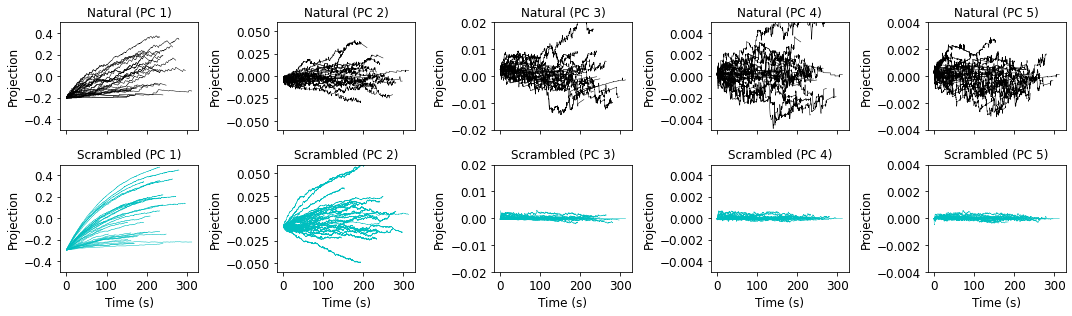

In [14]:
IPCS = range(5)
ntr_plot = 50

itr_xpl_plots = np.random.choice(np.arange(len(rs_full_xpl)), ntr_plot, replace=False)

fig, axs = plt.subplots(2, 5, figsize=(15, 4.5), tight_layout=True, sharex=True)

for itr in itr_xpl_plots:
    rs = rs_full_xpl[itr]
    rs_pca = pca.transform(rs)
    
    rs_scrambled = rs_full_xpl_scrambled[itr]
    rs_scrambled_pca = pca_scrambled.transform(rs_scrambled)
    
    t_snp = np.arange(len(rs))*DT
    
    for ipc, ax_col in zip(IPCS, axs.T):
        ax_col[0].plot(t_snp, rs_pca[:, ipc], c='k', lw=.5)
        ax_col[1].plot(t_snp, rs_scrambled_pca[:, ipc], c='c', lw=.5)
        
Y_LIMS = [(-.5, .5), (-.06, .06), (-.02, .02), (-.005, .005), (-.004, .004)]
    
for cax, (y_lim, ax_col) in enumerate(zip(Y_LIMS, axs.T)):
    set_plot(ax_col[0], y_lim=y_lim, y_label='Projection', title=f'Natural (PC {IPCS[cax]+1})')
    set_plot(ax_col[1], y_lim=y_lim, x_label='Time (s)', y_label='Projection', title=f'Scrambled (PC {IPCS[cax]+1})')
    
fig.savefig('ms/fig_4_pc_trajecs.svg')

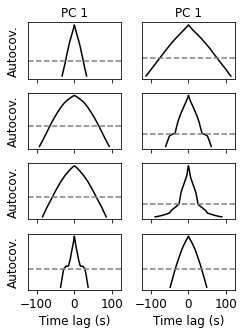

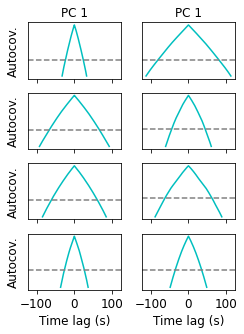

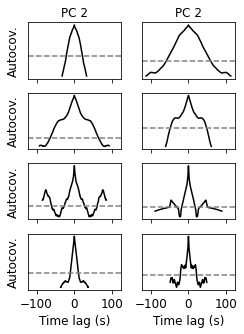

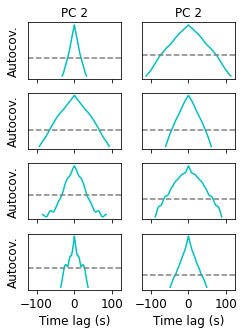

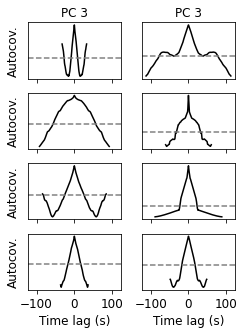

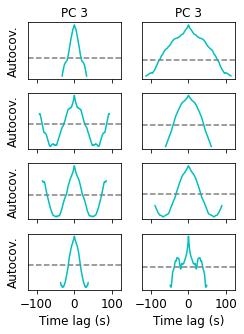

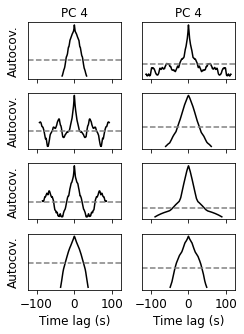

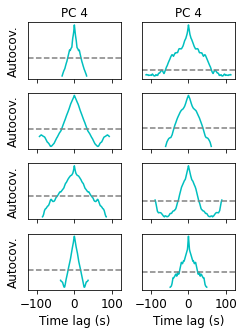

In [32]:
from time_stats import xcov_conv_tri

NXPL = 20
IPCS = range(4)
itr_xpl_plots = np.random.choice(np.arange(len(rs_full_xpl)), NXPL, replace=False)

# plot correlation functions
for ipc in IPCS:
    fig_nat, axs_nat = plt.subplots(4, 2, figsize=(3.5, 4.75), tight_layout=True, sharex=True)
    fig_scrm, axs_scrm = plt.subplots(4, 2, figsize=(3.5, 4.75), tight_layout=True, sharex=True)

    for citr, (itr, ax_nat, ax_scrm) in enumerate(zip(itr_xpl_plots, axs_nat.flat, axs_scrm.flat)):

        rs = rs_full_xpl[itr]
        rs_pca = pca.transform(rs)

        rs_scrambled = rs_full_xpl_scrambled[itr]
        rs_scrambled_pca = pca_scrambled.transform(rs_scrambled)

        t_snp = np.arange(len(rs))*DT

        xcov, itcov = xcov_conv_tri(rs_pca[:, ipc], rs_pca[:, ipc])
        tcov = DT*itcov

        mt = np.abs(tcov) < np.max(tcov)/2

        ax_nat.plot(tcov[mt], xcov[mt], c='k')

        xcov_scrambled, itcov = xcov_conv_tri(rs_scrambled_pca[:, ipc], rs_scrambled_pca[:, ipc])
        ax_scrm.plot(tcov[mt], xcov_scrambled[mt], c='c')

    for axs in [axs_nat, axs_scrm]:
        for ax in axs[0, :]:
            set_plot(ax, title=f'PC {ipc+1}')
        for ax in axs[-1, :]:
            set_plot(ax, x_label='Time lag (s)')
            
        for ax in axs.flat:
            ax.axhline(0, color='gray', ls='--')
            set_plot(ax, y_ticks=[])
            
        for ax in axs[:, 0]:
            set_plot(ax, y_label='Autocov.')

    fig_nat.savefig(f'ms/fig_4_autocovs_nat_pc_{ipc+1}.svg')
    fig_scrm.savefig(f'ms/fig_4_autocovs_scrm_pc_{ipc+1}.svg')

T_SNP 30: 8 snippets

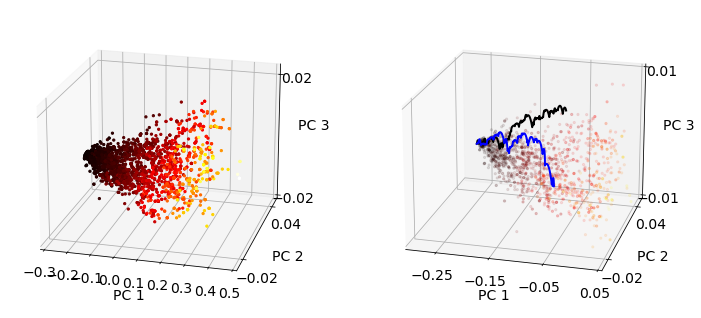

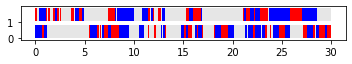

In [59]:
# get snippets
# T_SNPS = [30, 30]
T_SNP = 30


# for cT_SNP, T_SNP in enumerate(T_SNPS):
sys.stdout.write(f'T_SNP {T_SNP}: ')

NT_SNP = int(round(T_SNP*FPS))
t_snp = np.arange(NT_SNP)*DT

min_frac_sing = .5

snps = []

for csng, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
    segs = [sng_full[lb:ub] for lb, ub in bds]

    # keep fixed-length portions only of sufficiently long segments with sufficient singing
    segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP) and (np.mean(seg > 0) > min_frac_sing)]
    snps.extend(segs)

snps = np.array(snps)
nsnp = len(snps)

# i_ss = [(snp == 1).astype(float) for snp in snps]
# i_ps = [(snp == 2).astype(float) for snp in snps]

sys.stdout.write(f'{nsnp} snippets')

isnps = np.random.choice(range(len(snps)), 2, replace=False)

snps_store = []
rs_all = []
# basis = []

# fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

for isnp in isnps:
    snp = snps[isnp]
    i_s = (snp == 1).astype(float)
    i_p = (snp == 2).astype(float)

    t_snp = np.arange(len(snp))*DT

    rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]
    rs_all.append(rs)

    snps_store.append(snp)
        
rs_pca_all = [pca.transform(rs) for rs in rs_all]

# mdur = durs < np.inf
# energies = np.array(energies)

fig = plt.figure(figsize=(12, 7))

axs = []

colors = ['k', 'b']

for cax in range(2):
    
    ax = fig.add_subplot(121 + cax, projection='3d', computed_zorder=False)
    
    alpha = 1 if cax == 0 else 0.1
    mask = np.repeat(True, len(rs_final_pca)) if cax == 0 else (rs_final_pca[:, 0] < .05)
    ax.scatter(rs_final_pca[mask, 0], rs_final_pca[mask, 1], rs_final_pca[mask, 2], c=masses[mask], s=5, cmap='hot', alpha=alpha, zorder=0)
    
    if cax == 1:
        for crs_pca, rs_pca in enumerate(rs_pca_all):
            ax.plot(rs_pca[:, 0], rs_pca[:, 1], rs_pca[:, 2], lw=2, c=colors[crs_pca], zorder=1)
        
    ax.set_zlabel('PC 3')
    ax.view_init(elev=20, azim=-75)
                     
    if cax == 0:
        ax.set_zticks([-.02, .02])
    else:
        ax.set_zticks([-.01, .01])
    set_plot(ax, x_lim=(-0.3, .5), y_lim=(-.03, .05), y_ticks=[-.02, .04], x_label='PC 1', y_label='PC 2', font_size=14)
    
    if cax == 1:
        ax.set_zlim(-.01, .01)
        set_plot(ax, x_lim=(-.3, .05), x_ticks=[-.25, -.15, -.05, .05], font_size=14)
        
fig.savefig('ms/fig_4_manifold_diffusion.svg')

fig, ax = plt.subplots(1, 1, figsize=(5, 1), tight_layout=True)
for csnp, snp in enumerate(snps_store[:2]):
    t_snp = np.arange(len(snp))*DT
    plot_b(ax, t_snp, snp, extent=[0, t_snp.max(), csnp*1.1, csnp*1.1+.8], c=[(.9, .9, .9), 'b', 'r'])

fig.savefig('ms/fig_4_diffusion_songs.svg')